<a href="https://colab.research.google.com/github/joliveiraas/kvasir-seg/blob/main/UNETV2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data

### 1.1. Upload data

In [ ]:
import requests
import zipfile
from pathlib import Path

root = Path('root/')
data = root / 'data'

if not data.is_dir():
  data.mkdir(parents=True, exist_ok=True)

with open(root / 'data.zip', "wb") as f:
  request = requests.get('https://github.com/joliveiraas/kvasir-seg/raw/main/large%20data/kvasir-seg-large.zip')
  f.write(request.content)

  with zipfile.ZipFile(root / 'data.zip', 'r') as zip_ref:
    zip_ref.extractall(data)

In [ ]:
# Creating dir paths to store train and test data splits
train_imgs_path = data / 'train_images'
train_masks_path = data / 'train_masks'
test_imgs_path = data / 'test_images'
test_masks_path = data / 'test_masks'

In [ ]:
# Train and test split functions
import shutil
import os

def train_split(source, folder, size):

  try:
    if not os.path.exists(folder):
      os.makedirs(folder)

    imgs_list = os.listdir(source)
    train_imgs_paths = imgs_list[:size]

    # Images
    for file in train_imgs_paths:
      source_path = os.path.join(source, file)
      folder_path = os.path.join(folder, file)
      shutil.copy2(source_path, folder_path)

    print('Copy completed successfully.')

  except Exception as e:
    print(f'Error')

def test_split(source, folder, size):

  try:
    if not os.path.exists(folder):
      os.makedirs(folder)

    imgs_list = os.listdir(source)
    test_imgs_paths = imgs_list[-size:]

    # Images
    for file in test_imgs_paths:
      source_path = os.path.join(source, file)
      folder_path = os.path.join(folder, file)
      shutil.copy2(source_path, folder_path)

    print('Copy completed successfully.')

  except Exception as e:
    print(f'Error')

In [ ]:
images = data / 'images'
masks =  data / 'masks'

In [ ]:
train_imgs = train_split(images, train_imgs_path, 800)
train_masks = train_split(masks, train_masks_path, 800)
test_imgs = test_split(images, test_imgs_path, 200)
test_masks = test_split(masks, test_masks_path, 200)

Copy completed successfully.
Copy completed successfully.
Copy completed successfully.
Copy completed successfully.


In [ ]:
# Remove 'images' and 'masks' folders
try:
  shutil.rmtree(images)
  print(f'The {images} folder was removed successfully.')
except OSError as e:
  print(f'Error: {e}')

try:
  shutil.rmtree(masks)
  print(f'The {masks} folder was removed successfully.')
except OSError as e:
  print(f'Error: {e}')

The root/data/images folder was removed successfully.
The root/data/masks folder was removed successfully.


In [ ]:
# Walking through data (after split)
for dirpath, dirnames, filenames in os.walk(root):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 1 directories and 1 files in 'root'
There are 4 directories and 0 files in 'root/data'
There are 0 directories and 800 files in 'root/data/train_images'
There are 0 directories and 200 files in 'root/data/test_images'
There are 0 directories and 800 files in 'root/data/train_masks'
There are 0 directories and 200 files in 'root/data/test_masks'


### 1.2. Custom dataset class

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import os

class SegDataset(Dataset):
  def __init__(self, imgs_dir, masks_dir, transform=None):
    self.imgs_dir = imgs_dir
    self.masks_dir = masks_dir
    self.images = os.listdir(imgs_dir)
    self.masks = os.listdir(masks_dir)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.imgs_dir, self.images[idx])
    mask_path = os.path.join(self.masks_dir, self.images[idx])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)

    if self.transform is not None:
      image = self.transform(image)
      mask = self.transform(mask)

    return image, mask

### 1.3. Visualizing data (before transform)


Length of training data: 800


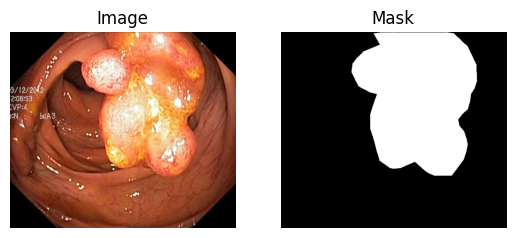

In [ ]:
import matplotlib.pyplot as plt
from random import randint

dataset = SegDataset(train_imgs_path, train_masks_path)
img, mask = dataset.__getitem__(randint(0, len(dataset)-1))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].axis(False)
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis(False)

print(f'Length of training data: {dataset.__len__()}')

### 1.4. Datasets


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
BATCH_SIZE = 32
PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
    transforms.ToTensor()
])

train_dataset = SegDataset(imgs_dir=train_imgs_path,
                           masks_dir=train_masks_path,
                           transform=transform)

test_dataset = SegDataset(imgs_dir=test_imgs_path,
                          masks_dir=test_masks_path,
                          transform=transform)
print(f'Lenght of train_dataset: {len(train_dataset)}')
print(f'Lenght of test_dataset: {len(test_dataset)}')

Lenght of train_dataset: 800
Lenght of test_dataset: 200


### 1.4.1 Visualizing data(after transform)

Original size: torch.Size([3, 128, 128]) -> [C, H, W]
Image permute: torch.Size([128, 128, 3]) -> [H, W, C]


(-0.5, 127.5, 127.5, -0.5)

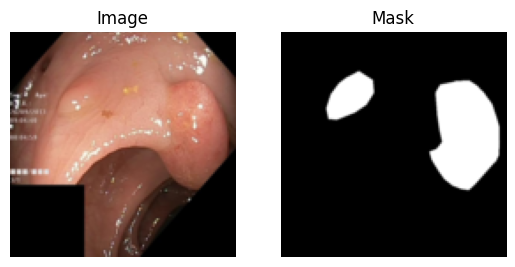

In [ ]:
from random import randint
idx = randint(0, len(dataset)-1)
img, mask = train_dataset[idx][0], train_dataset[idx][1]

img_permute = img.permute(1, 2, 0)
mask_permute = mask.permute(1, 2, 0)

print(f'Original size: {img.shape} -> [C, H, W]')
print(f'Image permute: {img_permute.shape} -> [H, W, C]')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_permute)
ax[0].set_title("Image")
ax[0].axis(False)
ax[1].imshow(mask_permute, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis(False)

### 1.5. Dataloaders

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              pin_memory=PIN_MEMORY,
                              num_workers=os.cpu_count()
                              )
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             pin_memory=PIN_MEMORY,
                             num_workers=os.cpu_count())
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec263b83fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec263ba8040>)

# 2. U-Net Model
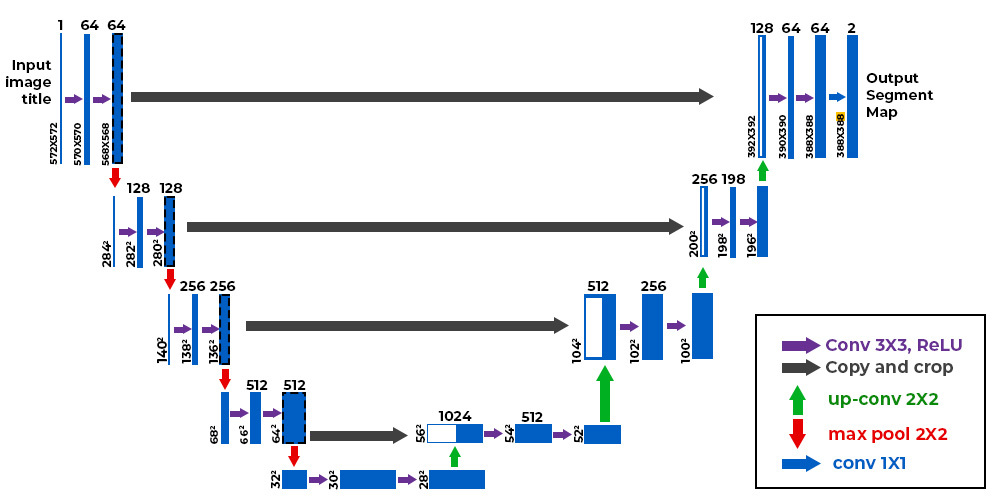

In [ ]:
import torch
from torch import nn
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3)
    )

  def forward(self, x):
    return self.conv_block(x)

class Encoder(nn.Module):
  def __init__(self, channels=(3, 64, 128, 256)):
    super().__init__()
    self.channels = channels
    self.blocks = nn.ModuleList(
        [ConvBlock(self.channels[i], self.channels[i+1])
            for i in range(len(self.channels)-1)
            ])
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    encoder_block = list()

    for block in self.blocks:
      x = block(x)
      encoder_block.append(x)
      x = self.pool(x)

    return encoder_block

class Decoder(nn.Module):
  def __init__(self, channels=(256, 128, 64)):
    super().__init__()
    self.channels = channels
    self.upconvs = nn.ModuleList(
        [nn.ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2)
          for i in range(len(self.channels)-1)]
    )
    self.decoder_block = nn.ModuleList(
        [ConvBlock(self.channels[i], self.channels[i+1])
          for i in range(len(self.channels)-1)]
    )

  def crop(self, enc_features, x):
    shape = x.shape[2:]
    enc_features = CenterCrop(shape)(enc_features)

    return enc_features

  def forward(self, x, enc_features):
    for i in range(len(self.channels)-1):
      x = self.upconvs[i](x)
      enc_feat = self.crop(enc_features[i], x)
      x = torch.cat([x, enc_feat], dim=1)
      x = self.decoder_block[i](x)

    return x

In [ ]:
class UNet(nn.Module):
  def __init__(self,
               enc_channels=(3, 64, 128, 256),
               dec_channels=(256, 128, 64),
               num_classes=1,
               retain_dim=True,
               out_size=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)
               ):
    super().__init__()
    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)

    self.head = nn.Conv2d(dec_channels[-1], num_classes, 1)
    self.retain_dim = retain_dim
    self.out_size = out_size

  def forward(self, x):
	  enc_features = self.encoder(x)

	  dec_features = self.decoder(enc_features[::-1][0], enc_features[::-1][1:])

	  map = self.head(dec_features)

	  if self.retain_dim:
	    map = F.interpolate(map, self.out_size)

	  return map

In [ ]:
def test():
  x = torch.randn((3, 3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)) # N, C, H, W
  model = UNet()
  preds = model(x)
  print(f'Input image shape: {x.shape}')
  print(f'Pred mask shape: {preds.shape}')

test()

Input image shape: torch.Size([3, 3, 128, 128])
Pred mask shape: torch.Size([3, 1, 128, 128])


# 3. Training

### 3.1. Training's hyperparameters and functions

In [ ]:
LR = 0.0001
EPOCHS = 60

In [ ]:
model = UNet().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

H = {"train_loss": [], "test_loss": []}

### 3.2. Training loop

In [ ]:
from timeit import default_timer as timer
from tqdm import tqdm
start = timer()
#torch.cuda.manual_seed(42)
for epoch in tqdm(range(EPOCHS)):
  ### Training
  model.train()
  train_loss = 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(train_dataset)

  ### Testing
  model.eval()
  test_loss = 0

  with torch.inference_mode():
    for (X, y) in test_dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
    test_loss /= len(test_dataset)

  ### Updates loss history dictionary
  H["train_loss"].append(train_loss.cpu().detach().numpy())
  H["test_loss"].append(test_loss.cpu().detach().numpy())

  ### Print what's happening
  print(f'\nEpoch: {epoch+1}/{EPOCHS} {"="*40}')
  print(f'Train loss: {train_loss:.5f}')
  print(f'Test loss: {test_loss:.5f}')

end = timer()
print(f'Total time on {DEVICE}: {end-start:.2f} seconds.')

  2%|▏         | 1/60 [00:11<11:39, 11.85s/it]


Epoch: 1/60 ========================================
Train loss: 0.01736
Test loss: 0.01652


  3%|▎         | 2/60 [00:19<09:03,  9.37s/it]


Epoch: 2/60 ========================================
Train loss: 0.01449
Test loss: 0.01537


  5%|▌         | 3/60 [00:28<08:53,  9.36s/it]


Epoch: 3/60 ========================================
Train loss: 0.01306
Test loss: 0.01396


  7%|▋         | 4/60 [00:37<08:26,  9.05s/it]


Epoch: 4/60 ========================================
Train loss: 0.01230
Test loss: 0.01363


  8%|▊         | 5/60 [00:46<08:14,  8.99s/it]


Epoch: 5/60 ========================================
Train loss: 0.01223
Test loss: 0.01346


 10%|█         | 6/60 [00:55<08:08,  9.05s/it]


Epoch: 6/60 ========================================
Train loss: 0.01211
Test loss: 0.01337


 12%|█▏        | 7/60 [01:03<07:42,  8.72s/it]


Epoch: 7/60 ========================================
Train loss: 0.01211
Test loss: 0.01335


 13%|█▎        | 8/60 [01:13<08:00,  9.24s/it]


Epoch: 8/60 ========================================
Train loss: 0.01204
Test loss: 0.01334


 15%|█▌        | 9/60 [01:23<07:53,  9.29s/it]


Epoch: 9/60 ========================================
Train loss: 0.01212
Test loss: 0.01324


 17%|█▋        | 10/60 [01:30<07:20,  8.81s/it]


Epoch: 10/60 ========================================
Train loss: 0.01204
Test loss: 0.01332


 18%|█▊        | 11/60 [01:40<07:20,  8.98s/it]


Epoch: 11/60 ========================================
Train loss: 0.01217
Test loss: 0.01326


 20%|██        | 12/60 [01:49<07:17,  9.12s/it]


Epoch: 12/60 ========================================
Train loss: 0.01208
Test loss: 0.01331


 22%|██▏       | 13/60 [01:57<06:54,  8.82s/it]


Epoch: 13/60 ========================================
Train loss: 0.01201
Test loss: 0.01334


 23%|██▎       | 14/60 [02:07<06:56,  9.06s/it]


Epoch: 14/60 ========================================
Train loss: 0.01204
Test loss: 0.01312


 25%|██▌       | 15/60 [02:16<06:47,  9.05s/it]


Epoch: 15/60 ========================================
Train loss: 0.01193
Test loss: 0.01310


 27%|██▋       | 16/60 [02:24<06:21,  8.67s/it]


Epoch: 16/60 ========================================
Train loss: 0.01190
Test loss: 0.01306


 28%|██▊       | 17/60 [02:33<06:19,  8.83s/it]


Epoch: 17/60 ========================================
Train loss: 0.01188
Test loss: 0.01303


 30%|███       | 18/60 [02:41<06:01,  8.61s/it]


Epoch: 18/60 ========================================
Train loss: 0.01185
Test loss: 0.01296


 32%|███▏      | 19/60 [02:50<05:56,  8.70s/it]


Epoch: 19/60 ========================================
Train loss: 0.01188
Test loss: 0.01301


 33%|███▎      | 20/60 [02:59<05:55,  8.89s/it]


Epoch: 20/60 ========================================
Train loss: 0.01185
Test loss: 0.01294


 35%|███▌      | 21/60 [03:07<05:34,  8.58s/it]


Epoch: 21/60 ========================================
Train loss: 0.01173
Test loss: 0.01292


 37%|███▋      | 22/60 [03:17<05:34,  8.81s/it]


Epoch: 22/60 ========================================
Train loss: 0.01173
Test loss: 0.01272


 38%|███▊      | 23/60 [03:26<05:32,  8.99s/it]


Epoch: 23/60 ========================================
Train loss: 0.01167
Test loss: 0.01276


 40%|████      | 24/60 [03:34<05:12,  8.69s/it]


Epoch: 24/60 ========================================
Train loss: 0.01170
Test loss: 0.01261


 42%|████▏     | 25/60 [03:44<05:12,  8.93s/it]


Epoch: 25/60 ========================================
Train loss: 0.01170
Test loss: 0.01262


 43%|████▎     | 26/60 [03:53<05:07,  9.05s/it]


Epoch: 26/60 ========================================
Train loss: 0.01161
Test loss: 0.01275


 45%|████▌     | 27/60 [04:01<04:50,  8.79s/it]


Epoch: 27/60 ========================================
Train loss: 0.01144
Test loss: 0.01253


 47%|████▋     | 28/60 [04:10<04:44,  8.90s/it]


Epoch: 28/60 ========================================
Train loss: 0.01142
Test loss: 0.01237


 48%|████▊     | 29/60 [04:19<04:32,  8.79s/it]


Epoch: 29/60 ========================================
Train loss: 0.01131
Test loss: 0.01224


 50%|█████     | 30/60 [04:28<04:23,  8.80s/it]


Epoch: 30/60 ========================================
Train loss: 0.01127
Test loss: 0.01231


 52%|█████▏    | 31/60 [04:37<04:20,  8.97s/it]


Epoch: 31/60 ========================================
Train loss: 0.01113
Test loss: 0.01200


 53%|█████▎    | 32/60 [04:45<04:00,  8.58s/it]


Epoch: 32/60 ========================================
Train loss: 0.01109
Test loss: 0.01215


 55%|█████▌    | 33/60 [04:54<04:00,  8.89s/it]


Epoch: 33/60 ========================================
Train loss: 0.01103
Test loss: 0.01192


 57%|█████▋    | 34/60 [05:03<03:53,  8.99s/it]


Epoch: 34/60 ========================================
Train loss: 0.01101
Test loss: 0.01212


 58%|█████▊    | 35/60 [05:11<03:34,  8.59s/it]


Epoch: 35/60 ========================================
Train loss: 0.01097
Test loss: 0.01189


 60%|██████    | 36/60 [05:20<03:30,  8.78s/it]


Epoch: 36/60 ========================================
Train loss: 0.01100
Test loss: 0.01166


 62%|██████▏   | 37/60 [05:29<03:21,  8.78s/it]


Epoch: 37/60 ========================================
Train loss: 0.01080
Test loss: 0.01165


 63%|██████▎   | 38/60 [05:37<03:10,  8.65s/it]


Epoch: 38/60 ========================================
Train loss: 0.01076
Test loss: 0.01186


 65%|██████▌   | 39/60 [05:47<03:06,  8.87s/it]


Epoch: 39/60 ========================================
Train loss: 0.01065
Test loss: 0.01175


 67%|██████▋   | 40/60 [05:55<02:52,  8.64s/it]


Epoch: 40/60 ========================================
Train loss: 0.01062
Test loss: 0.01156


 68%|██████▊   | 41/60 [06:04<02:46,  8.77s/it]


Epoch: 41/60 ========================================
Train loss: 0.01074
Test loss: 0.01175


 70%|███████   | 42/60 [06:14<02:42,  9.01s/it]


Epoch: 42/60 ========================================
Train loss: 0.01071
Test loss: 0.01155


 72%|███████▏  | 43/60 [06:21<02:26,  8.64s/it]


Epoch: 43/60 ========================================
Train loss: 0.01063
Test loss: 0.01146


 73%|███████▎  | 44/60 [06:31<02:22,  8.92s/it]


Epoch: 44/60 ========================================
Train loss: 0.01054
Test loss: 0.01149


 75%|███████▌  | 45/60 [06:40<02:16,  9.10s/it]


Epoch: 45/60 ========================================
Train loss: 0.01039
Test loss: 0.01175


 77%|███████▋  | 46/60 [06:49<02:03,  8.81s/it]


Epoch: 46/60 ========================================
Train loss: 0.01040
Test loss: 0.01142


 78%|███████▊  | 47/60 [06:58<01:57,  9.05s/it]


Epoch: 47/60 ========================================
Train loss: 0.01042
Test loss: 0.01140


 80%|████████  | 48/60 [07:08<01:49,  9.15s/it]


Epoch: 48/60 ========================================
Train loss: 0.01044
Test loss: 0.01137


 82%|████████▏ | 49/60 [07:15<01:36,  8.77s/it]


Epoch: 49/60 ========================================
Train loss: 0.01033
Test loss: 0.01128


 83%|████████▎ | 50/60 [07:25<01:29,  8.93s/it]


Epoch: 50/60 ========================================
Train loss: 0.01034
Test loss: 0.01142


 85%|████████▌ | 51/60 [07:34<01:20,  8.97s/it]


Epoch: 51/60 ========================================
Train loss: 0.01013
Test loss: 0.01132


 87%|████████▋ | 52/60 [07:42<01:10,  8.81s/it]


Epoch: 52/60 ========================================
Train loss: 0.01014
Test loss: 0.01130


 88%|████████▊ | 53/60 [07:52<01:03,  9.03s/it]


Epoch: 53/60 ========================================
Train loss: 0.01010
Test loss: 0.01117


 90%|█████████ | 54/60 [08:00<00:51,  8.66s/it]


Epoch: 54/60 ========================================
Train loss: 0.01015
Test loss: 0.01110


 92%|█████████▏| 55/60 [08:08<00:43,  8.73s/it]


Epoch: 55/60 ========================================
Train loss: 0.00997
Test loss: 0.01117


 93%|█████████▎| 56/60 [08:18<00:35,  8.89s/it]


Epoch: 56/60 ========================================
Train loss: 0.01006
Test loss: 0.01136


 95%|█████████▌| 57/60 [08:26<00:25,  8.64s/it]


Epoch: 57/60 ========================================
Train loss: 0.00994
Test loss: 0.01097


 97%|█████████▋| 58/60 [08:35<00:17,  8.93s/it]


Epoch: 58/60 ========================================
Train loss: 0.01000
Test loss: 0.01103


 98%|█████████▊| 59/60 [08:45<00:09,  9.05s/it]


Epoch: 59/60 ========================================
Train loss: 0.00983
Test loss: 0.01100


100%|██████████| 60/60 [08:53<00:00,  8.89s/it]


Epoch: 60/60 ========================================
Train loss: 0.00978
Test loss: 0.01146
Total time on cuda: 533.32 seconds.


### 3.3. Visualizing training process

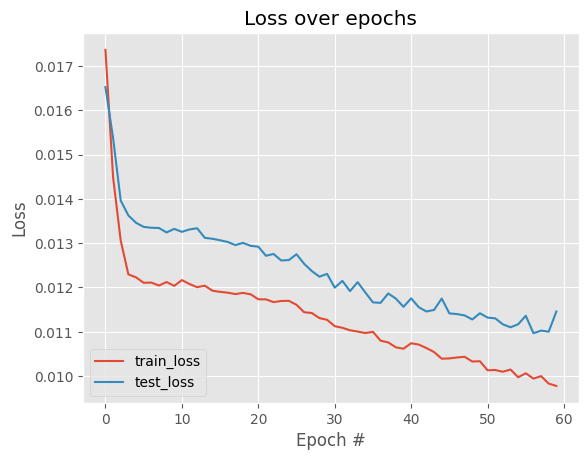

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

# 4. Using the trained model for prediction

In [ ]:
THRESHOLD = 0.4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def prepare_plot(img, true_mask, pred_mask):
  fig, ax = plt.subplots(1, 3, figsize=(5, 5))

  ax[0].imshow(img)
  ax[0].set_title("Image")
  ax[1].imshow(true_mask)
  ax[1].set_title("Original mask")
  ax[2].imshow(pred_mask)
  ax[2].set_title("Predicted mask")

  fig.tight_layout()
  fig.show()

In [ ]:
def make_predictions(model, img_path):
  model.eval()

  with torch.inference_mode():
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0

    image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
    orig = image.copy()

    filename = img_path.split(os.path.sep)[-1]
    true_mask_path = os.path.join(test_masks_path, filename)

    true_mask = cv2.imread(true_mask_path, 0)
    true_mask = cv2.resize(true_mask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))

    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(DEVICE)

    pred_mask = model(image).squeeze()
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = pred_mask.cpu().numpy()

    pred_mask = (pred_mask > THRESHOLD) * 255
    pred_mask = pred_mask.astype(np.uint8)

    prepare_plot(orig, true_mask, pred_mask)

Loading up test image paths...


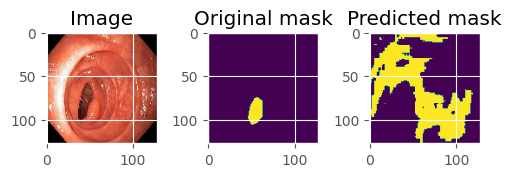

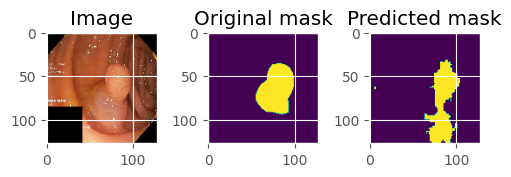

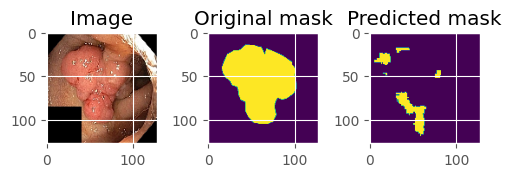

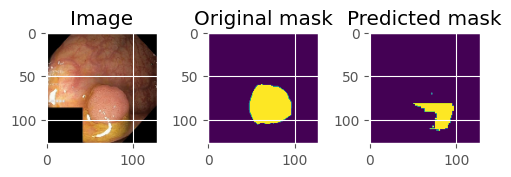

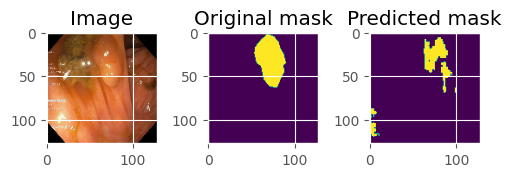

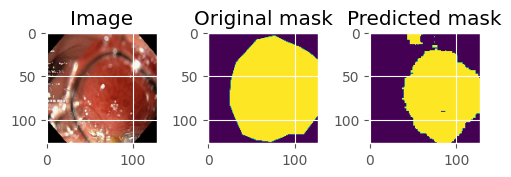

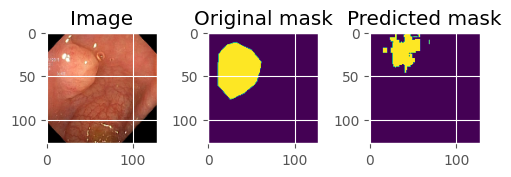

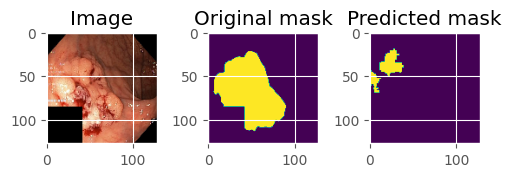

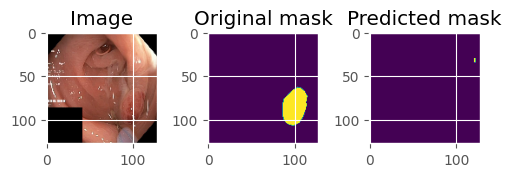

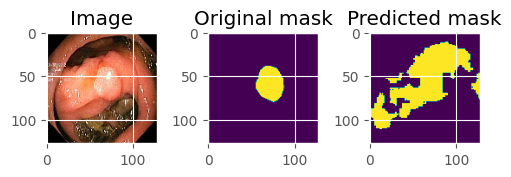

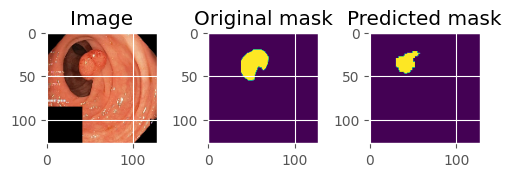

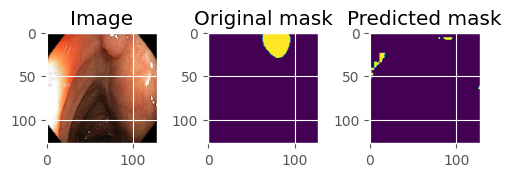

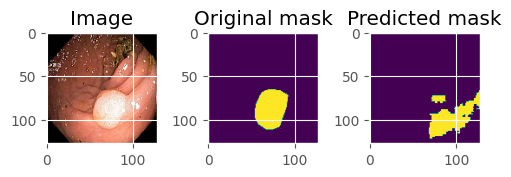

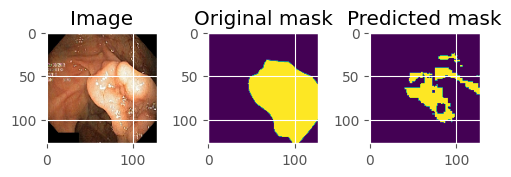

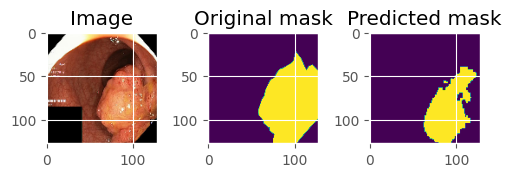

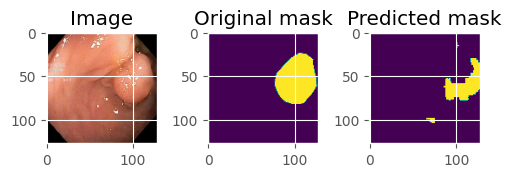

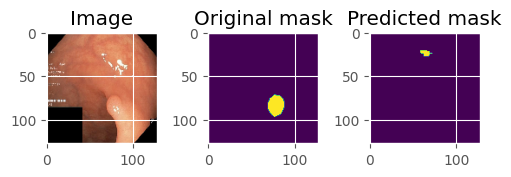

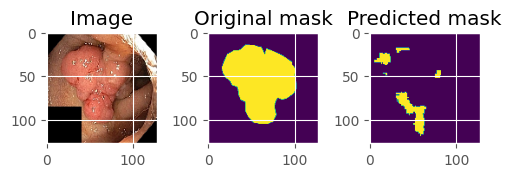

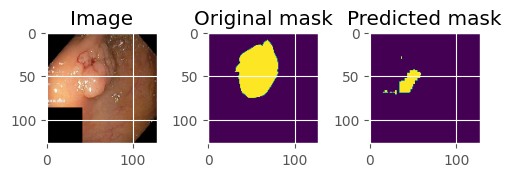

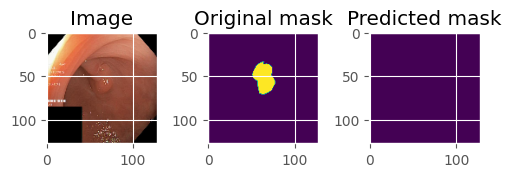

In [ ]:
print('Loading up test image paths...')
imgs_paths = [os.path.join(test_imgs_path, filename) for filename in os.listdir(test_imgs_path)]
#imgs_list = imgs_paths[10:20]
imgs_list = np.random.choice(imgs_paths, size=20)
print

for path in imgs_list:
  make_predictions(model, path)